<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_02_auto_ml_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML

In [0]:
COLAB = True

In [9]:
if COLAB:
  !sudo apt-get install git-lfs && git lfs install
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  #!cd dl-projects && ls -l --block-size=M

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (2,197 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-pr

In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .

In [0]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import math 
import matplotlib

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display

from utils import *
from preprocess import *

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [13]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [14]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [15]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/"feature_matrix.csv"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/'4D.zip'

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 1151M
-rw------- 1 root root 407M Dec 30 05:00 feature_matrix_2.csv
-rw------- 1 root root 428M Dec 30 05:01 feature_matrix_2.pkl
-rw------- 1 root root 141M Dec 27 08:27 feature_matrix.csv
-rw------- 1 root root 176M Dec 27 08:28 feature_matrix.pkl
total 1M
-rw-r--r-- 1 root root 1M Jan  1 14:39 4D.txt
-rw-r--r-- 1 root root 1M Jan  1 14:39 4D.zip


In [0]:
data = pd.read_csv(DATASET, header=0, sep=',', quotechar='"', parse_dates=['time'])
origin_data = format_tabular(ORIGIN_DATASET)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699972 entries, 0 to 699971
Data columns (total 53 columns):
NumberId                                   699972 non-null int64
time                                       699972 non-null datetime64[ns]
SUM(Results.DrawNo)                        699972 non-null int64
SUM(Results.LuckyNo)                       699972 non-null int64
SUM(Results.TotalStrike)                   699972 non-null int64
STD(Results.DrawNo)                        699575 non-null float64
STD(Results.LuckyNo)                       699575 non-null float64
STD(Results.TotalStrike)                   699575 non-null float64
MAX(Results.DrawNo)                        699972 non-null int64
MAX(Results.LuckyNo)                       699972 non-null int64
MAX(Results.TotalStrike)                   699972 non-null int64
SKEW(Results.DrawNo)                       696365 non-null float64
SKEW(Results.LuckyNo)                      696365 non-null float64
SKEW(Results.TotalStrike)

## Exploratory Data Analysis

In [0]:
feature_matrix = data

In [19]:
feature_matrix.columns

Index(['NumberId', 'time', 'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
       'SUM(Results.TotalStrike)', 'STD(Results.DrawNo)',
       'STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
       'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
       'MAX(Results.TotalStrike)', 'SKEW(Results.DrawNo)',
       'SKEW(Results.LuckyNo)', 'SKEW(Results.TotalStrike)',
       'MIN(Results.DrawNo)', 'MIN(Results.LuckyNo)',
       'MIN(Results.TotalStrike)', 'MEAN(Results.DrawNo)',
       'MEAN(Results.LuckyNo)', 'MEAN(Results.TotalStrike)', 'COUNT(Results)',
       'NUM_UNIQUE(Results.PrizeType)', 'DAY(first_Results_time)',
       'YEAR(first_Results_time)', 'MONTH(first_Results_time)',
       'WEEKDAY(first_Results_time)', 'TotalStrike', 'Label',
       'MODE(Results.PrizeType)_1stPrizeNo',
       'MODE(Results.PrizeType)_2ndPrizeNo',
       'MODE(Results.PrizeType)_3rdPrizeNo',
       'MODE(Results.PrizeType)_ConsolationNo1',
       'MODE(Results.PrizeType)_ConsolationNo10',
       'MODE(Res

In [20]:
feature_matrix.head(4).T

,0,1,2,3
NumberId,0,1,2,3
time,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-01 00:00:00
SUM(Results.DrawNo),1857929,1571202,898913,1628516
SUM(Results.LuckyNo),0,9,8,24
SUM(Results.TotalStrike),8,9,4,8
STD(Results.DrawNo),116257,96697.5,49525.7,116135
STD(Results.LuckyNo),0,0,0,0
STD(Results.TotalStrike),0,0,0,0
MAX(Results.DrawNo),394013,363311,265606,393913
MAX(Results.LuckyNo),0,1,2,3


In [21]:
origin_data[origin_data['LuckyNo']==0].head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo
11686,91595,1995-08-02,3rdPrizeNo,0
21541,134398,1998-04-26,SpecialNo1,0
23100,141198,1998-10-01,ConsolationNo5,0
30430,173000,2000-09-09,2ndPrizeNo,0
48346,251005,2005-06-04,1stPrizeNo,0
56190,285107,2007-06-06,2ndPrizeNo,0
79783,387613,2013-05-04,SpecialNo6,0
81258,394013,2013-09-14,SpecialNo9,0
82908,401214,2014-02-08,SpecialNo3,0
85712,413414,2014-10-18,SpecialNo10,0


Text(0, 0.5, 'Strike Per Number')

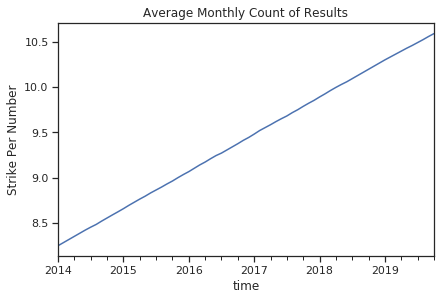

In [22]:
feature_matrix.groupby('time')['COUNT(Results)'].mean().plot()
plt.title('Average Monthly Count of Results')
plt.ylabel('Strike Per Number')

## Feature Selection

In [23]:
from utils import feature_selection

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'NumberId']))

Original shape:  (699972, 51)
0 missing columns with threshold: 90.
7 zero variance columns.
5 collinear columns removed with threshold: 0.95.
Total columns removed:  12
Shape after feature selection: (699972, 39).


In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['NumberId'] = feature_matrix['NumberId']
feature_matrix_selection['Label'] = feature_matrix['Label']

In [26]:
feature_matrix_selection.columns

Index(['SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
       'SUM(Results.TotalStrike)', 'STD(Results.DrawNo)',
       'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)', 'SKEW(Results.DrawNo)',
       'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)',
       'NUM_UNIQUE(Results.PrizeType)', 'DAY(first_Results_time)',
       'MONTH(first_Results_time)', 'WEEKDAY(first_Results_time)',
       'TotalStrike', 'MODE(Results.PrizeType)_1stPrizeNo',
       'MODE(Results.PrizeType)_2ndPrizeNo',
       'MODE(Results.PrizeType)_3rdPrizeNo',
       'MODE(Results.PrizeType)_ConsolationNo1',
       'MODE(Results.PrizeType)_ConsolationNo10',
       'MODE(Results.PrizeType)_ConsolationNo2',
       'MODE(Results.PrizeType)_ConsolationNo3',
       'MODE(Results.PrizeType)_ConsolationNo4',
       'MODE(Results.PrizeType)_ConsolationNo5',
       'MODE(Results.PrizeType)_ConsolationNo6',
       'MODE(Results.PrizeType)_ConsolationNo7',
       'MODE(Results.PrizeType)_ConsolationNo8',
       'MODE(Results.PrizeType

## Correlations

In [27]:
feature_matrix_selection.shape

(699972, 42)

In [28]:
corrs = feature_matrix_selection.corr().sort_values('TotalStrike')
corrs['TotalStrike'].head()

MODE(Results.PrizeType)_SpecialNo8       -0.003139
MODE(Results.PrizeType)_ConsolationNo9   -0.002791
year                                     -0.002787
MAX(Results.LuckyNo)                     -0.002340
NumberId                                 -0.002340
Name: TotalStrike, dtype: float64

In [29]:
corrs['Label'].dropna().tail(8)

SUM(Results.TotalStrike)              0.002338
MODE(Results.PrizeType)_SpecialNo9    0.002180
MODE(Results.PrizeType)_SpecialNo6    0.002528
MAX(Results.DrawNo)                   0.003222
MEAN(Results.DrawNo)                  0.003457
SUM(Results.DrawNo)                   0.003557
Label                                 1.000000
TotalStrike                           0.991613
Name: Label, dtype: float64

In [30]:
corrs['TotalStrike'].dropna().tail(8)

SUM(Results.TotalStrike)              0.002227
MODE(Results.PrizeType)_SpecialNo9    0.002269
MODE(Results.PrizeType)_SpecialNo6    0.002818
MAX(Results.DrawNo)                   0.003362
MEAN(Results.DrawNo)                  0.003483
SUM(Results.DrawNo)                   0.003516
Label                                 0.991613
TotalStrike                           1.000000
Name: TotalStrike, dtype: float64

## Visualization

In [0]:
#pip install autoviz

In [0]:
#from autoviz.AutoViz_Class import AutoViz_Class

### CatBoost

In [33]:
!pip install catboost
!pip install ipywidgets

In [0]:
import catboost as cgb

In [0]:
model = cgb.CatBoostClassifier(eval_metric="AUC", depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate= 0.15)

In [0]:
def predict_dt(dt, feature_matrix, return_probs = False):

    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    print(f"Size of test labels {len(test_labels)}")
    print(f"Size of train labels {len(train_labels)}")
    
    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    print(f"Size of X train {len(X_train)}")
    print(f"Size of X test  {len(X_test)}")
   
    feature_names = list(X_train.columns)
    
    # Impute and scale features
    pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    p = precision_score(y_test, predictions)
    r = recall_score(y_test, predictions)
    f = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, probs)
    a = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    print(f'Precision: {round(p, 5)}')
    print(f'Recall: {round(r, 5)}')
    print(f'F1 Score: {round(f, 5)}')
    print(f'ROC AUC: {round(auc, 5)}')
    print(f'Accuracy: {round(a, 5)}')
    print(probs)
    print()
    print(cm)

    m = np.where(predictions==1)
    print(len(m[0]), m)

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi
    

In [37]:
# All the months
len(feature_matrix_selection['time'].unique()), feature_matrix_selection['time'].unique()

(70, array(['2014-01-01T00:00:00.000000000', '2014-02-01T00:00:00.000000000',
        '2014-03-01T00:00:00.000000000', '2014-04-01T00:00:00.000000000',
        '2014-05-01T00:00:00.000000000', '2014-06-01T00:00:00.000000000',
        '2014-07-01T00:00:00.000000000', '2014-08-01T00:00:00.000000000',
        '2014-09-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
        '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
        '2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
        '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
        '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
        '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
        '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
        '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
        '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
        '2016-03-01T00:00:00.00000

In [38]:
 %time june_2019 = predict_dt(pd.datetime(2019,6,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 649972
Size of X train 649972
Size of X test  10000
Training on 649972 observations.
Testing on 10000 observations.

Learning rate set to 0.104755
0:	learn: 0.5446039	total: 237ms	remaining: 3m 56s
1:	learn: 0.4365679	total: 423ms	remaining: 3m 30s
2:	learn: 0.3588705	total: 614ms	remaining: 3m 24s
3:	learn: 0.3030070	total: 786ms	remaining: 3m 15s
4:	learn: 0.2626110	total: 978ms	remaining: 3m 14s
5:	learn: 0.2332434	total: 1.18s	remaining: 3m 15s
6:	learn: 0.2117650	total: 1.38s	remaining: 3m 15s
7:	learn: 0.1959275	total: 1.57s	remaining: 3m 14s
8:	learn: 0.1841529	total: 1.76s	remaining: 3m 13s
9:	learn: 0.1753623	total: 1.94s	remaining: 3m 12s
10:	learn: 0.1687139	total: 2.15s	remaining: 3m 13s
11:	learn: 0.1636599	total: 2.35s	remaining: 3m 13s
12:	learn: 0.1598144	total: 2.53s	remaining: 3m 11s
13:	learn: 0.1568591	total: 2.72s	remaining: 3m 11s
14:	learn: 0.1545835	total: 2.91s	remaining: 3m 10s
15:	learn: 0.1528205	total: 3.12s	re

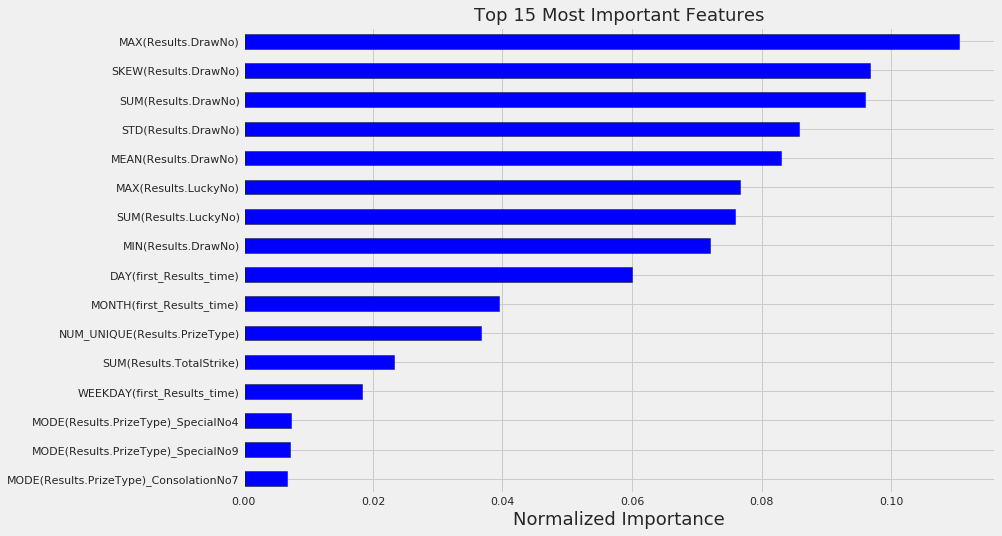

In [39]:
from utils import plot_feature_importances

norm_june_2019_fi = plot_feature_importances(june_2019)

In [0]:
%time july_2019 = predict_dt(pd.datetime(2019,7,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 659972
Size of X train 659972
Size of X test  10000
Training on 659972 observations.
Testing on 10000 observations.

Learning rate set to 0.105208
0:	learn: 0.5440289	total: 201ms	remaining: 3m 20s
1:	learn: 0.4357426	total: 392ms	remaining: 3m 15s
2:	learn: 0.3580786	total: 576ms	remaining: 3m 11s
3:	learn: 0.3021571	total: 777ms	remaining: 3m 13s
4:	learn: 0.2618208	total: 989ms	remaining: 3m 16s
5:	learn: 0.2325557	total: 1.22s	remaining: 3m 21s
6:	learn: 0.2111777	total: 1.42s	remaining: 3m 22s
7:	learn: 0.1954318	total: 1.64s	remaining: 3m 23s
8:	learn: 0.1837696	total: 1.82s	remaining: 3m 20s
9:	learn: 0.1750251	total: 2.03s	remaining: 3m 21s
10:	learn: 0.1684322	total: 2.23s	remaining: 3m 20s
11:	learn: 0.1634369	total: 2.41s	remaining: 3m 18s
12:	learn: 0.1596246	total: 2.61s	remaining: 3m 18s
13:	learn: 0.1567008	total: 2.81s	remaining: 3m 17s
14:	learn: 0.1544529	total: 2.99s	remaining: 3m 16s
15:	learn: 0.1527146	total: 3.18s	re

In [0]:
norm_july_2019_fi = plot_feature_importances(july_2019)

### Tuning - GridSearch

## Comparison to Baseline

In [0]:
a = np.array([0,0,0,1,0,1, 1])
print(len(a))
m = np.where(a==1)
print(len(m[0]), a[m[0]])